https://colab.research.google.com/github/bentrevett/pytorch-pos-tagging/blob/master/2%20-%20Fine-tuning%20Pretrained%20Transformers%20for%20PoS%20Tagging.ipynb#scrollTo=WIOmo6FYXU_4

https://github.com/bentrevett/pytorch-pos-tagging/blob/master/2%20-%20Fine-tuning%20Pretrained%20Transformers%20for%20PoS%20Tagging.ipynb

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext import datasets

from transformers import BertTokenizer, BertModel

import numpy as np

import time
import random
import functools

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, pad_token, unk_token)

In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, pad_token_idx, unk_token_idx)

pretrain_model이 최대 길이까지 시퀀스에 대해 학습되었으며 시퀀스도 이 길이로 잘리는 지 확인해야 한다.

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

첫 번째는 사전 훈련 된 모델에 지정된 원하는 최대 길이로 토큰 시퀀스를 자른 다음 어휘를 통해 토큰을 전달하여 토큰을 인덱스로 변환합니다. 이것은 태그를 지정하려는 입력 시퀀스에 사용할 것입니다.

실제로 토큰을 max_input_length-1로 자릅니다. 이는 시퀀스의 시작 부분에 특수 [CLS] 토큰을 추가해야하기 때문입니다.

In [ ]:
# 토큰의 길이가 최대 512 - 1 을 넘지안도록 자른 후 인코딩화 (맨 처음에 [CLS]를 추가하기 위해 - 1)
def cut_and_convert_to_id(tokens, tokenizer, max_input_length):
    tokens = tokens[:max_input_length-1]
    tokens = tokenizer.convert_tokens_to_ids(tokens)
    return tokens

In [ ]:
test_token = 'this'

test = cut_and_convert_to_id(test_token, tokenizer, max_input_length)
print(test)

두 번째는 단순히 시퀀스를 최대 길이로 자릅니다. 이것은 우리의 태그에 사용됩니다. 어휘는 품사 태그가 아닌 영어문장 용으로만 작성되었으므로 사전 훈련 된 모델의 어휘를 통해 태그를 전달하지 않습니다. 우리 스스로 태그 어휘를 구축 할 것입니다.

In [ ]:
def cut_to_max_length(tokens, max_input_length):
    tokens = tokens[:max_input_length-1]
    return tokens

In [ ]:
test_token = 'this'

test = cut_to_max_length(test_token, max_input_length)
print(test)

In [ ]:
# functools.partial : 기존 파이썬 함수를 재사용하여 일부 위치 매개변수 또는 키워드 매개변수를 고정한(freezed, fixec) 상태에서, 원래의 함수처럼 작동하는 새로운 부분 객체(partial object)를 반환

text_preprocessor = functools.partial(cut_and_convert_to_id,
                                      tokenizer = tokenizer,
                                      max_input_length = max_input_length)

tag_preprocessor = functools.partial(cut_to_max_length,
                                     max_input_length = max_input_length)

In [ ]:
TEXT = data.Field(use_vocab = False, 
                  lower = True,
                  preprocessing = text_preprocessor,
                  init_token = init_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

UD_TAGS = data.Field(unk_token = None,
                     init_token = '<pad>',
                     preprocessing = tag_preprocessor)

In [ ]:
fields = (("text", TEXT), ("udtags", UD_TAGS))

In [ ]:
train_data, valid_data, test_data = datasets.UDPOS.splits(fields)

In [ ]:
example_index = 0

sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['udtags']

print(sentence)
# al - zaman : american forces killed shaikh abdullah al - ani , the preacher at the mosque in the town of qaim , near the syrian border .
print(' '.join(tokenizer.convert_ids_to_tokens(sentence)))
print(actual_tags)

PROPN : proper noun(고유명사) \
PUNCT : punctuation(구두점) \
DET : determiner(한정사) \
NOUN : noun(명사) \
ADP : adposition(전치사와 후치사를 포함하는 용어) \
ADJ : adjective(형용사) \
AUX : auxiliary(조동사) \
VERB : verb(동사) \
PRON : pronoun(대명사) \
PART : particle(의미를 부여하기 위해 다른 단어와 연관되어야하며 다른 보편적인 품사의 정의를 충족하지 않는 기능어)

In [ ]:
UD_TAGS.build_vocab(train_data)
print(UD_TAGS.vocab.stoi)

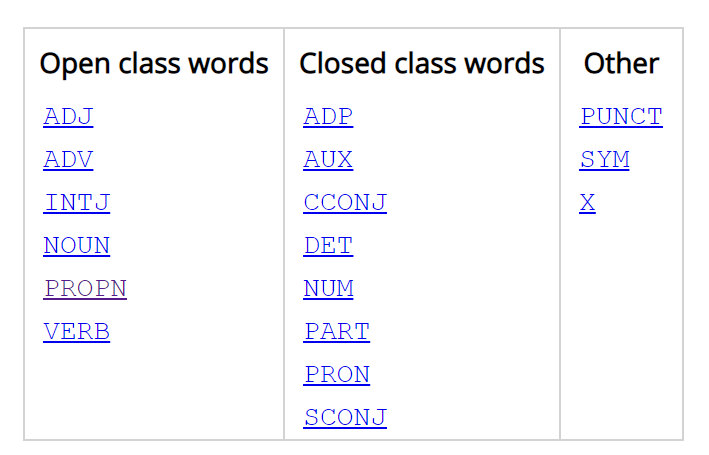

https://universaldependencies.org/u/pos/all.html#al-u-pos/PROPN

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                          batch_size = BATCH_SIZE,
                                                                          device = device)

In [ ]:
class BERTPoSTagger(nn.Module):
    def __init__(self, bert, output_dim, dropout):      
        super().__init__()    
        self.bert = bert       
        embedding_dim = bert.config.to_dict()['hidden_size']  # bert.config.to_dict() : dict화  
        self.fc = nn.Linear(embedding_dim, output_dim)     
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # print(text.shape) : torch.Size([46, 32]) [text_length, batch_size]
        text = text.permute(1, 0)
        # premute(1, 0) : 1 ↔ 0 차원 바꿈
        # print(text.shape) : torch.Size([32, 46])
        
        # print(self.bert(text)[0].shape) : torch.Size([32, 30, 768]) [batch_size, text_length, 'bert-base-uncased'의 hidden layer]
        embedded = self.dropout(self.bert(text)[0])
        # print(embedded.shape) : torch.Size([32, 46, 768]) [batch_size, text_lengths, 'bert-base-uncased'의 hidden layer]

        embedded = embedded.permute(1, 0, 2)
        # permute(1, 0, 2) : 0 ↔ 1 차원바꾸고 2차원은 그대로
        # print(embedded.shape) : torch.Size([46, 32, 768])
        
        predictions = self.fc(self.dropout(embedded))
        # print(predictions.shape) : torch.Size([43, 32, 18]) [text_length, batch_size, len(UD_TAGS.vocab) == output_dim]
        
        return predictions

In [ ]:
bert = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
OUTPUT_DIM = len(UD_TAGS.vocab)
DROPOUT = 0.25

model = BERTPoSTagger(bert,
                      OUTPUT_DIM, 
                      DROPOUT)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
LEARNING_RATE = 5e-5

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]]).to(device)

In [ ]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.udtags
                
        optimizer.zero_grad()
        
        #text = [sent len, batch size]
        
        predictions = model(text)
        
        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.udtags
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
def tag_sentence(model, device, sentence, tokenizer, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        tokens = tokenizer.tokenize(sentence)
    else:
        tokens = sentence
    
    numericalized_tokens = tokenizer.convert_tokens_to_ids(tokens)
    numericalized_tokens = [text_field.init_token] + numericalized_tokens
        
    unk_idx = text_field.unk_token
    
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
         
    predictions = model(token_tensor)
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    predicted_tags = predicted_tags[1:]
        
    assert len(tokens) == len(predicted_tags)
    
    return tokens, predicted_tags, unks

In [ ]:
sentence = 'The Queen will deliver a speech about the conflict in North Korea at 1pm tomorrow.'

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence,
                                  tokenizer,
                                  TEXT, 
                                  UD_TAGS)

print(unks)

In [ ]:
print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")